# Package and datasets

In [2]:
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
dataset_path = "D:\\Casper\\OTHER\\Data\\MNIST_data"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [3]:
def filter_indices(dataset, classes):
    indices = []
    for i in range(len(dataset)):
        if dataset.targets[i] in classes:
            indices.append(i)
    return indices

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
    ])
full_dataset = datasets.MNIST(root=dataset_path, train=True, download=False, transform=transform)

filtered_indices = filter_indices(full_dataset, [1, 3, 5, 7])
filtered_dataset = Subset(full_dataset, filtered_indices)
print(f"Full dataset: {len(full_dataset)}")
print(f"Filtered dataset: {len(filtered_dataset)}")


Full dataset: 60000
Filtered dataset: 24559


Label: 0


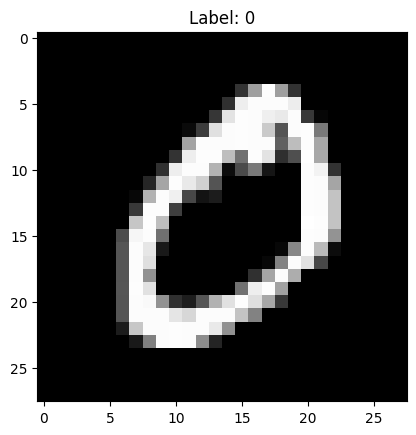

Label: 1


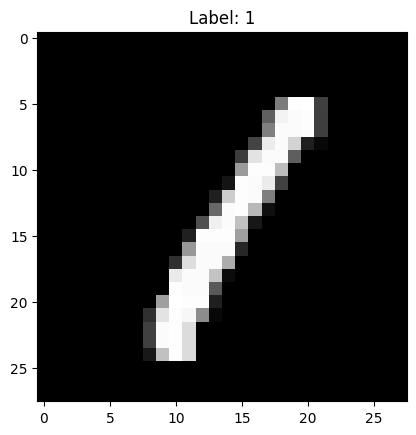

In [4]:
def display_image_and_tensor(dataset, index):
    image, label = dataset[index]  # Get the first image and its label
    
    print("Label:", label)
    image_np = image.squeeze().numpy()  

    plt.imshow(image_np, cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()

display_image_and_tensor(full_dataset, 1)
display_image_and_tensor(filtered_dataset, 1)

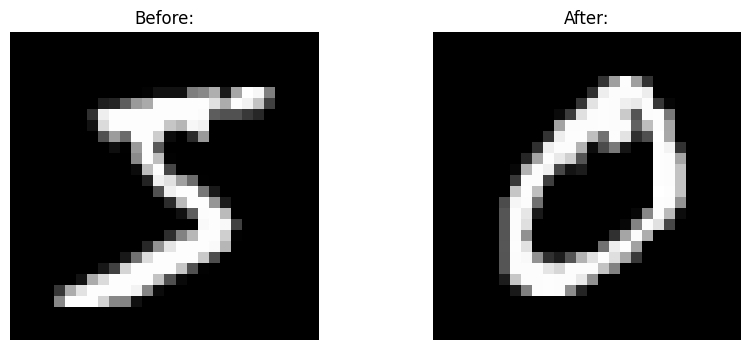

In [5]:
def plot_two_tensors(tensor1, tensor2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Create a figure with two subplots

    axes[0].imshow(tensor1.squeeze(), cmap='gray')  # Remove channel dimension if exists and plot
    axes[0].set_title(f'Before:')
    axes[0].axis('off')  # Hide axes ticks

    axes[1].imshow(tensor2.squeeze(), cmap='gray')
    axes[1].set_title(f'After:')
    axes[1].axis('off')

    plt.show()
plot_two_tensors(full_dataset[0][0], full_dataset[1][0])  

In [6]:

def get_dataloaders(dataset, train_ratio, val_ratio, batch_size, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    train_dataset = dataset
    val_dataset = dataset
    test_dataset = dataset
    # obtain training indices that will be used for validation
    num_train = len(test_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)

    train_loader = DataLoader(merge_dataset, batch_size=batch_size)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size)
    test_loader = DataLoader(Subset(test_dataset, test_idx), batch_size=batch_size)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders
dataloaders = get_dataloaders(filtered_dataset, 0.8, 1, 64, 6452916)
full_dataloaders = get_dataloaders(full_dataset, 0.8, 1, 64, 6452916)


--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [12235, 16413, 3163, 5348, 21316]
--------- INDEX shuffled ---------

Total number of samples: 24559 datapoints
Number of train samples: 307 batches/ 19647 datapoints
Number of val samples: 77 batches/ 4912 datapoints
Number of test samples: 0 batches/ 0 datapoints

--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [56774, 32710, 56427, 49406, 20372]
--------- INDEX shuffled ---------

Total number of samples: 60000 datapoints
Number of train samples: 750 batches/ 48000 datapoints
Number of val samples: 188 batches/ 12000 datapoints
Number of test samples: 0 batches/ 0 datapoints



In [7]:
def count_parameters(model):
    total_num = 0

    for parameter in model.parameters():
        if parameter.requires_grad:
            total_num += parameter.numel() 
    return total_num

## 1. Image Classifier

In [8]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Output: 16 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Output: 16 x 14 x 14
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),# Output: 32 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_net = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, len([1, 3, 5, 7]))
        )

    def forward(self, x):
        x = self.conv_net(x)
        x = x.view(x.size(0), -1)
        x = self.fc_net(x)
        return x


### Train image classifier

In [9]:
label_mapping = {1: 0, 3: 1, 5: 2, 7: 3}

def transform_labels(labels):
    transformed_labels = torch.tensor([label_mapping[label.item()] for label in labels])
    return transformed_labels


In [10]:
model = DigitClassifier().to(device)
print(f"Model: DigitClassifier")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 5

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for images, labels in tqdm(dataloaders['train']):
        labels = transform_labels(labels)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}\n[TRAIN] Accuracy: {100 * correct / total:.2f}%, Loss: {running_loss / total}')

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(dataloaders['val']):
            labels = transform_labels(labels)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    print(f'[VALID] Accuracy: {100 * correct / total:.2f}%, Loss: {running_loss / total}\n')


Model: DigitClassifier
model total parameters: 206,148


100%|██████████| 307/307 [00:02<00:00, 103.05it/s]


Epoch 1
[TRAIN] Accuracy: 96.62%, Loss: 0.0014701480491506782


100%|██████████| 77/77 [00:00<00:00, 256.75it/s]


[VALID] Accuracy: 99.10%, Loss: 0.0005023135178760741



100%|██████████| 307/307 [00:01<00:00, 216.27it/s]


Epoch 2
[TRAIN] Accuracy: 99.25%, Loss: 0.00035087779617953027


100%|██████████| 77/77 [00:00<00:00, 265.61it/s]


[VALID] Accuracy: 99.25%, Loss: 0.0004146425882687603



100%|██████████| 307/307 [00:01<00:00, 219.36it/s]


Epoch 3
[TRAIN] Accuracy: 99.34%, Loss: 0.0003160550165506342


100%|██████████| 77/77 [00:00<00:00, 240.68it/s]


[VALID] Accuracy: 99.12%, Loss: 0.0004070306682102745



100%|██████████| 307/307 [00:01<00:00, 185.00it/s]


Epoch 4
[TRAIN] Accuracy: 99.63%, Loss: 0.00018116716000244313


100%|██████████| 77/77 [00:00<00:00, 220.07it/s]


[VALID] Accuracy: 99.21%, Loss: 0.00036719438655473803



100%|██████████| 307/307 [00:01<00:00, 174.49it/s]


Epoch 5
[TRAIN] Accuracy: 99.69%, Loss: 0.00015958934986763705


100%|██████████| 77/77 [00:00<00:00, 213.96it/s]

[VALID] Accuracy: 99.02%, Loss: 0.00045736266539436325



### Abnormal Detection

In [88]:

normal_labels = torch.tensor([1, 3, 5, 7], device=device)
best_acc = 0
best_ii = 0

for ii in range(20):
    anomaly_threshold = ii * 0.05

    model.eval()
    total, correct = 0, 0
    anomalies = []
    with torch.no_grad():
        for images, labels in tqdm(full_dataloaders['val']):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            max_probs, predictions = torch.max(probabilities, dim=1)
            anomaly_mask = max_probs > anomaly_threshold


            # Check if each label in the batch is from the trained set (1, 3, 5, 7)
            is_normal = torch.isin(labels, normal_labels)

            correct_preds = (is_normal & ~anomaly_mask) | (~is_normal & anomaly_mask)
            correct += correct_preds.sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    if accuracy > best_acc:
        best_acc = accuracy
        best_ii = ii
    print(f'Anomaly detection accuracy: {accuracy:.2f}% \nAnomaly_threshold: {ii*0.05}\n')

print(f'Anomaly detection accuracy: {best_acc:.2f}% \nAnomaly_threshold: {best_ii*0.05}')

100%|██████████| 188/188 [00:01<00:00, 170.97it/s]


Anomaly detection accuracy: 57.96% 
Anomaly_threshold: 0.0



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 57.96% 
Anomaly_threshold: 0.05



100%|██████████| 188/188 [00:01<00:00, 166.43it/s]


Anomaly detection accuracy: 57.96% 
Anomaly_threshold: 0.1



100%|██████████| 188/188 [00:01<00:00, 164.97it/s]


Anomaly detection accuracy: 57.96% 
Anomaly_threshold: 0.15000000000000002



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 57.96% 
Anomaly_threshold: 0.2



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 57.96% 
Anomaly_threshold: 0.25



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 57.96% 
Anomaly_threshold: 0.30000000000000004



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 57.95% 
Anomaly_threshold: 0.35000000000000003



100%|██████████| 188/188 [00:01<00:00, 166.43it/s]


Anomaly detection accuracy: 57.88% 
Anomaly_threshold: 0.4



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 57.69% 
Anomaly_threshold: 0.45



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 57.32% 
Anomaly_threshold: 0.5



100%|██████████| 188/188 [00:01<00:00, 166.43it/s]


Anomaly detection accuracy: 56.27% 
Anomaly_threshold: 0.55



100%|██████████| 188/188 [00:01<00:00, 166.43it/s]


Anomaly detection accuracy: 55.08% 
Anomaly_threshold: 0.6000000000000001



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 53.73% 
Anomaly_threshold: 0.65



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 52.43% 
Anomaly_threshold: 0.7000000000000001



100%|██████████| 188/188 [00:01<00:00, 169.43it/s]


Anomaly detection accuracy: 50.98% 
Anomaly_threshold: 0.75



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 49.48% 
Anomaly_threshold: 0.8



100%|██████████| 188/188 [00:01<00:00, 167.91it/s]


Anomaly detection accuracy: 47.77% 
Anomaly_threshold: 0.8500000000000001



100%|██████████| 188/188 [00:01<00:00, 166.43it/s]


Anomaly detection accuracy: 45.42% 
Anomaly_threshold: 0.9



100%|██████████| 188/188 [00:01<00:00, 167.92it/s]

Anomaly detection accuracy: 41.71% 
Anomaly_threshold: 0.9500000000000001

Anomaly detection accuracy: 57.96% 
Anomaly_threshold: 0.0


## 2. Normal Autoencoder

In [1]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            # nn.ReLU(True),
            # nn.Linear(12, 3)  # Compressed representation
        )
        self.decoder = nn.Sequential(
            # nn.Linear(3, 12),
            # nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


NameError: name 'nn' is not defined

### Train normal autoencoder

In [121]:
model = Autoencoder().to(device)
print(f"Model: Autoencoder")
model_parameters_amount = count_parameters(model)
print(f"model total parameters: {model_parameters_amount:,}")

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for images, _ in tqdm(dataloaders['train']):
        images = images.to(device)
        images = images.view(images.size(0), -1)
        images.requires_grad_()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total += images.size(0)
        running_loss += loss.item()


    print(f'Epoch {epoch+1}\n[TRAIN] Loss: {running_loss / total}')

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(dataloaders['val']):
            images = images.to(device)
            images = images.view(images.size(0), -1)
            images.requires_grad_()
            
            outputs = model(images)
            loss = criterion(outputs, images)
            total += images.size(0)
            running_loss += loss.item()

    print(f'[VALID] Loss: {running_loss / total}\n')


Model: Autoencoder
model total parameters: 219,804


  0%|          | 0/307 [00:00<?, ?it/s]


TypeError: len() of a 0-d tensor

### Result Visualization

  0%|          | 0/77 [00:00<?, ?it/s]

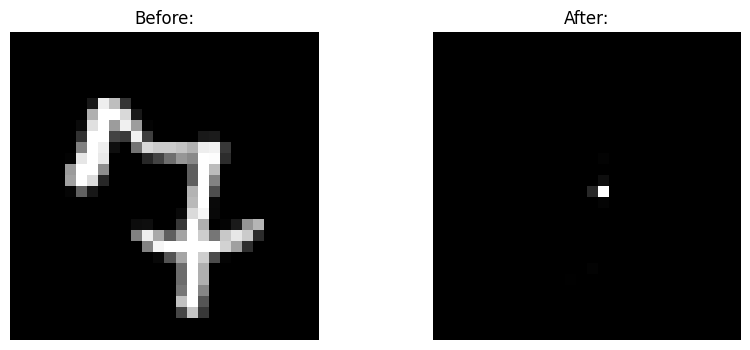

  0%|          | 0/77 [00:00<?, ?it/s]


In [112]:
index = 50
with torch.no_grad():
    for images, _ in tqdm(dataloaders['val']):
        images = images.to(device)
        images = images.view(images.size(0), -1)
        
        outputs = model(images)
        plot_two_tensors(images[index].cpu().view(28,28), outputs[index].cpu().view(28,28))
        break


### abnormal detection

In [119]:

normal_labels = torch.tensor([1, 3, 5, 7], device=device)
best_acc = 0
best_ii = 0

for ii in range(20):
    anomaly_threshold = ii * 0.05

    model.eval()
    total, correct = 0, 0
    anomalies = []
    with torch.no_grad():
        for images, _ in tqdm(full_dataloaders['val']):
            images = images.to(device)
            images = images.view(images.size(0), -1)

            outputs = model(images)
            loss = criterion(outputs, images).item()
            print(len(images))
            print(len(loss))
            probabilities = F.softmax(loss, dim=1)
            max_probs, predictions = torch.max(probabilities, dim=1)
            anomaly_mask = max_probs > anomaly_threshold


            # Check if each label in the batch is from the trained set (1, 3, 5, 7)
            is_normal = torch.isin(labels, normal_labels)

            correct_preds = (is_normal & ~anomaly_mask) | (~is_normal & anomaly_mask)
            correct += correct_preds.sum().item()
            total += labels.size(0)
            break
    accuracy = 100 * correct / total
    if accuracy > best_acc:
        best_acc = accuracy
        best_ii = ii
    print(f'Anomaly detection accuracy: {accuracy:.2f}% \nAnomaly_threshold: {ii*0.05}\n')

print(f'Anomaly detection accuracy: {best_acc:.2f}% \nAnomaly_threshold: {best_ii*0.05}')

  0%|          | 0/188 [00:00<?, ?it/s]

64


TypeError: object of type 'float' has no len()

## 3. Denoising Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)  # Compressed representation
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### Train image classifier

### abnormal detection

## 4. Variational autoencoder

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)  # Mean output
        self.fc22 = nn.Linear(400, 20)  # Variance output

        # Decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### Train image classifier

### abnormal detection

## 5. Isolated Forrest

### Train image classifier

### abnormal detection

## 6. Isolated Forrest with pre-trained feature extractor.

### Train image classifier

### abnormal detection

## 7. Comparison and Conclusion

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL divergence losses summed over all elements and batch
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
epochs = 15

# Data loader
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Model
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print(f'Epoch {epoch + 1}, Average Loss: {train_loss / len(train_loader.dataset):.4f}')

In [ ]:
def add_noise(imgs, noise_factor=0.5):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
    return noisy_imgs


model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
for epoch in range(num_epochs):
    for data in dataloader:
        imgs, _ = data
        noisy_imgs = add_noise(imgs)
        noisy_imgs = noisy_imgs.view(noisy_imgs.size(0), -1)
        outputs = model(noisy_imgs)
        
        loss = criterion(outputs, noisy_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



KeyboardInterrupt: 

In [ ]:


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img.requires_grad_()

        # Forward pass
        output = model(img)
        loss = criterion(output, img)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
# torch.save(model.state_dict(), 'autoencoder.pth')


Epoch [1/10], Loss: 0.9373
Epoch [2/10], Loss: 0.9317
Epoch [3/10], Loss: 0.9312
Epoch [4/10], Loss: 0.9350
Epoch [5/10], Loss: 0.9311
Epoch [6/10], Loss: 0.9363
Epoch [7/10], Loss: 0.9311
Epoch [8/10], Loss: 0.9345
Epoch [9/10], Loss: 0.9316
Epoch [10/10], Loss: 0.9358


In [ ]:
# Load the test dataset
test_dataset = datasets.MNIST(root=dataset_path, train=False, download=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Threshold for reconstruction error
threshold = 0.1  # This might need to be adjusted based on validation results

# Check against the test dataset
model.eval()
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = img.view(img.size(0), -1)
        
        output = model(img)
        loss = criterion(output, img).item()
        # print(f"Detected anomaly for digit {label.item()} with loss {loss}")
        
        if loss > threshold and label not in [1, 3, 5, 7]:
            print(f"Detected anomaly for digit {label.item()} with loss {loss}")


Detected anomaly for digit 9 with loss 0.9909002184867859
Detected anomaly for digit 4 with loss 1.0015134811401367
Detected anomaly for digit 6 with loss 1.002133846282959
Detected anomaly for digit 4 with loss 0.9710438847541809
Detected anomaly for digit 4 with loss 1.0244098901748657
Detected anomaly for digit 6 with loss 0.9551548361778259
Detected anomaly for digit 6 with loss 0.981257975101471
Detected anomaly for digit 0 with loss 1.0078688859939575
Detected anomaly for digit 4 with loss 1.0073007345199585
Detected anomaly for digit 4 with loss 0.9888672828674316
Detected anomaly for digit 2 with loss 1.0171527862548828
Detected anomaly for digit 9 with loss 0.9410939812660217
Detected anomaly for digit 9 with loss 1.0354684591293335
Detected anomaly for digit 8 with loss 0.9168937802314758
Detected anomaly for digit 2 with loss 0.9461975693702698
Detected anomaly for digit 6 with loss 1.0251712799072266
Detected anomaly for digit 9 with loss 0.9890202879905701
Detected anomaly

Detected anomaly for digit 6 with loss 0.9891842603683472
Detected anomaly for digit 9 with loss 0.9992719888687134
Detected anomaly for digit 2 with loss 0.9558824300765991
Detected anomaly for digit 4 with loss 0.9886878728866577
Detected anomaly for digit 9 with loss 1.0031237602233887
Detected anomaly for digit 0 with loss 0.9593518376350403
Detected anomaly for digit 4 with loss 1.0251260995864868
Detected anomaly for digit 2 with loss 0.9794428944587708
Detected anomaly for digit 8 with loss 0.9970491528511047
Detected anomaly for digit 0 with loss 0.929133415222168
Detected anomaly for digit 6 with loss 0.9586114883422852
Detected anomaly for digit 6 with loss 0.9925577640533447
Detected anomaly for digit 9 with loss 0.9322428107261658
Detected anomaly for digit 6 with loss 1.0425351858139038
Detected anomaly for digit 6 with loss 0.9821008443832397
Detected anomaly for digit 8 with loss 0.9479804635047913
Detected anomaly for digit 4 with loss 0.9430786371231079
Detected anomal